# Committor Guided Estimates of Molecular Transition Rates
Mitchell & Rotskoff
Presented by Connor Blake

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import MDAnalysis as mda
import mdshare
import mdtraj as md

In [2]:
local_filename = mdshare.fetch('alanine-dipeptide-nowater.pdb')
l0 = mdshare.fetch('alanine-dipeptide-0-250ns-nowater.xtc')
l1 = mdshare.fetch('alanine-dipeptide-1-250ns-nowater.xtc')
l2 = mdshare.fetch('alanine-dipeptide-2-250ns-nowater.xtc')

In [3]:
traj = md.load("alanine-dipeptide-0-250ns-nowater.xtc",top="alanine-dipeptide-nowater.pdb")

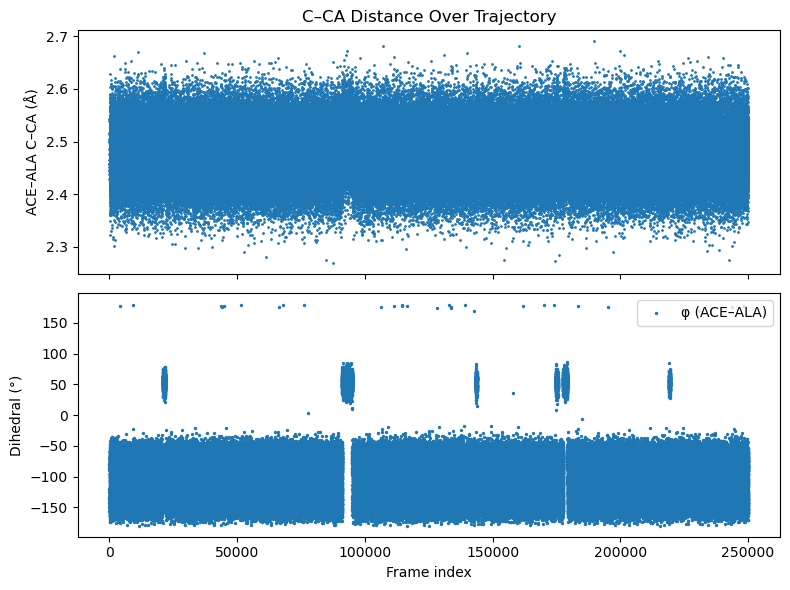

In [4]:
top = traj.topology
ace_c   = top.select('resname ACE and name C')[0]
ala_ca  = top.select('resname ALA and name CA')[0]
C_ACE, N_ALA, CA_ALA, C_ALA, N_NME = (
    top.select('resname ACE and name C')[0],
    top.select('resname ALA and name N')[0],
    top.select('resname ALA and name CA')[0],
    top.select('resname ALA and name C')[0],
    top.select('resname NME and name N')[0],
)

# 3) Compute distances vectorized (nm → Å)
distances = md.compute_distances(traj, [[ace_c, ala_ca]])[:, 0] * 10.0

# 4) Compute φ/ψ dihedrals vectorized (radians)
phi   = md.compute_dihedrals(traj, [[C_ACE, N_ALA, CA_ALA, C_ALA]])[:, 0]
psi   = md.compute_dihedrals(traj, [[N_ALA, CA_ALA, C_ALA, N_NME]])[:, 0]

# 5) Pack angles into a 2×N array (convert to degrees)
angles = np.vstack((np.degrees(phi), np.degrees(psi)))

# 6) Plot
frames = np.arange(traj.n_frames)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].plot(frames, distances, '.', ms=2)
ax[0].set_ylabel('ACE–ALA C–CA (Å)')
ax[0].set_title('C–CA Distance Over Trajectory')

ax[1].scatter(frames, angles[0], s=2, label='φ (ACE–ALA)')
# ax[1].scatter(frames, angles[1], s=2, label='ψ (ALA–NME)')
ax[1].set_ylabel('Dihedral (°)')
ax[1].set_xlabel('Frame index')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

## pyEMMA

In [7]:
import pyemma
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
# for visualization of molecular structures:
import nglview
import mdtraj
from threading import Timer

In [9]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

print(data.shape)

(100000, 2)


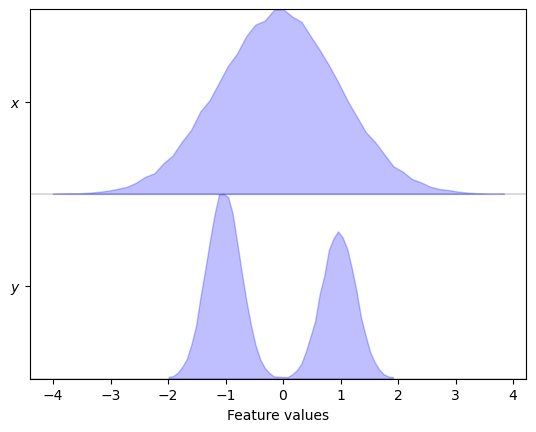

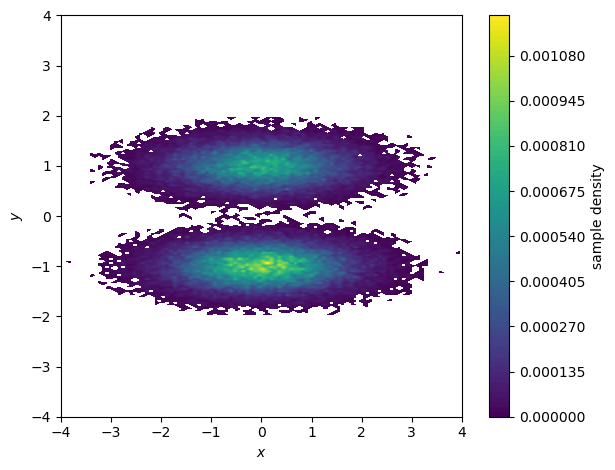

In [11]:
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$']);
fig, ax, misc = pyemma.plots.plot_density(*data.T)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()

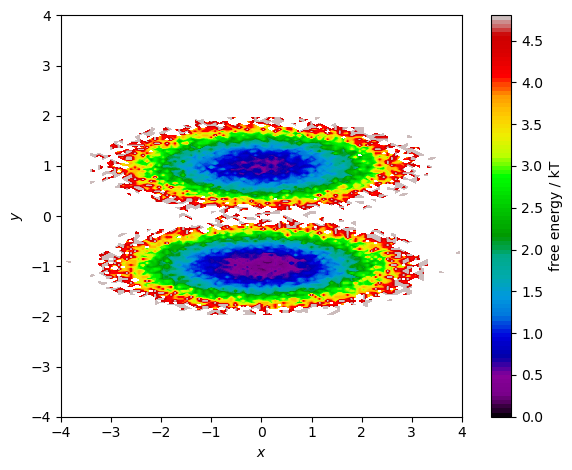

In [12]:
fig, ax, misc = pyemma.plots.plot_free_energy(*data.T, legacy=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()

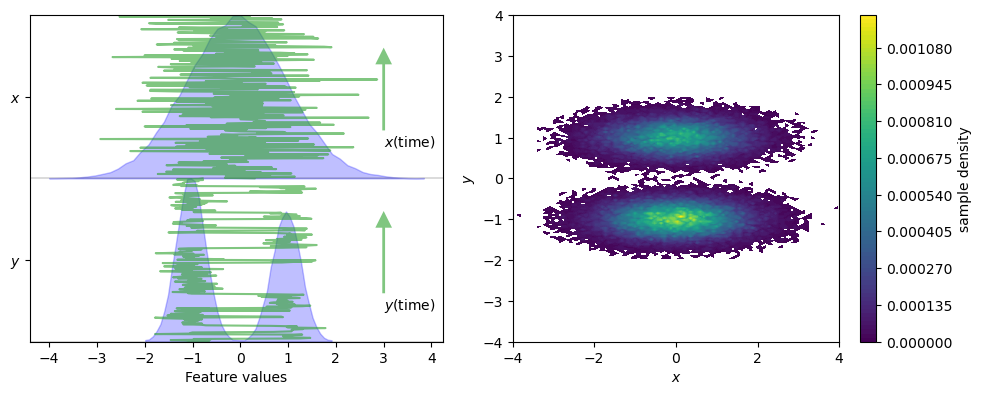

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
for i, dim in enumerate(['y', 'x']):
    axes[0].plot(data[:300, 1 - i], np.linspace(-0.2 + i, 0.8 + i, 300), color='C2', alpha=0.6)
    axes[0].annotate(
        '${}$(time)'.format(dim),
        xy=(3, 0.6 + i),
        xytext=(3, i),
        arrowprops=dict(fc='C2', ec='None', alpha=0.6, width=2))
pyemma.plots.plot_density(*data.T, ax=axes[1])
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.tight_layout()

In [16]:
cluster_kmeans = pyemma.coordinates.cluster_kmeans(data, k=100, stride=5, max_iter=100)
print(cluster_kmeans)

/home/cjblake/miniconda3/envs/md_sims/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cjblake/miniconda3/envs/md_sims/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

KmeansClustering(clustercenters=array([[-2.05972,  1.36149],
       [ 0.39991, -0.40263],
       ...,
       [-0.12914, -0.42117],
       [-0.18839,  1.05944]], dtype=float32),
         fixed_seed=1357804433, init_strategy='kmeans++', keep_data=False,
         max_iter=100, metric='euclidean', n_clusters=100, n_jobs=16,
         oom_strategy='memmap', skip=0, stride=5, tolerance=1e-05)


/home/cjblake/miniconda3/envs/md_sims/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_regspace". Called from /home/cjblake/miniconda3/envs/md_sims/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.clustering.RegularSpace instead.
  return caller(func, *(extras + args), **kw)


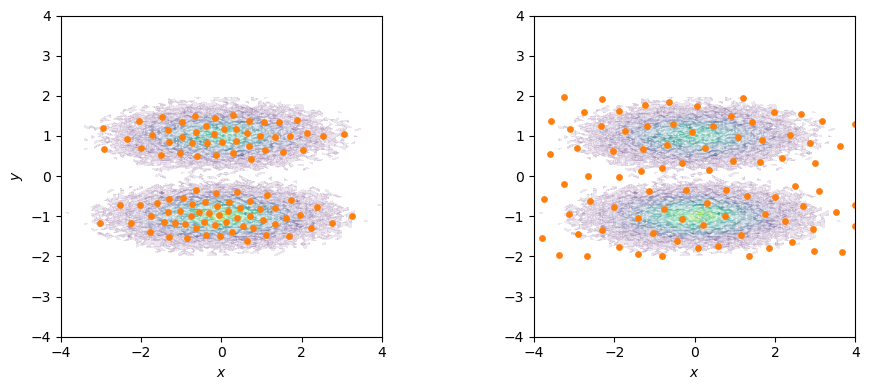

In [18]:
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, cls in zip(axes.flat, [cluster_kmeans, cluster_regspace]):
    pyemma.plots.plot_density(*data.T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cls.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$x$')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
axes[0].set_ylabel('$y$')
fig.tight_layout()

In [20]:
pca = pyemma.coordinates.pca(data, dim=1)
pca_output = pca.get_output()
print(pca_output)

[array([[-0.26751208],
       [ 0.37113857],
       [-0.35730326],
       ...,
       [-0.55788803],
       [ 0.9381754 ],
       [-0.73651516]], dtype=float32)]


/home/cjblake/miniconda3/envs/md_sims/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "pca". Called from /home/cjblake/miniconda3/envs/md_sims/lib/python3.9/site-packages/decorator.py line 235. Use sklearn.decomposition.PCA instead.
  return caller(func, *(extras + args), **kw)


## PCCA+

In [127]:
import numpy as np
import deeptime

# 1. Discretize domain
N = 100
x = np.linspace(-5.0, 5.0, N)

# 2. Define potential U(x) and inverse temperature beta
beta = 1.0
U = np.cos(x + .5) + 0.08 * x**2

# 3. Compute equilibrium distribution p ∝ exp(-beta * U)
p_unnorm = np.exp(-beta * U)
p_eq = p_unnorm / p_unnorm.sum()    # shape (N,)

# 4. Build reversible Markov transition matrix P via Metropolis random walk
P = np.zeros((N, N))
for i in range(N):
    # propose moves to neighbors i-1, i+1 with equal probability
    for j in (i-1, i+1):
        if 0 <= j < N:
            P[i, j] = 0.5 * min(1.0, p_eq[j] / p_eq[i])
    # stay probability
    P[i, i] = 1.0 - P[i].sum()

# Optional check: detailed balance p_i P[i,j] = p_j P[j,i]
assert np.allclose(p_eq[:, None] * P, p_eq[None, :] * P.T)

# P is your stochastic matrix (shape 100×100)
# p_eq is the equilibrium distribution over the 100 grid points


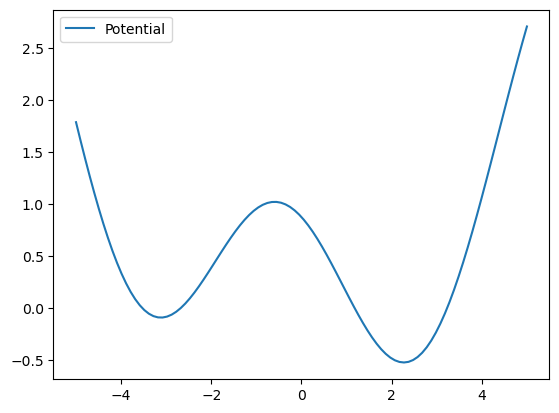

In [128]:
plt.plot(x,U,label="Potential")
plt.legend()
plt.show()

In [136]:
N_splits = 4
out = deeptime.markov.pcca(P,N_splits)

In [137]:
def entropy(p):
    p = np.asarray(p)
    p = p[p > 0]
    return -np.sum(p * np.log(p))

In [138]:
for i in range(2,10):
    model_i = deeptime.markov.pcca(P,i)
    print(i,entropy(model_i.coarse_grained_stationary_probability)/np.log(i))

2 0.9754019014982211
3 0.938634967580288
4 0.7365039684677994
5 0.9424665968841756
6 0.939806216385057
7 0.9323333142571107
8 0.907029924814504
9 0.8909871540887754


In [139]:
out.coarse_grained_stationary_probability

array([0.55981754, 0.26682803, 0.16274114, 0.0106133 ])

In [140]:
print(entropy(out.coarse_grained_stationary_probability))

1.021011298429332


12.30308004328114


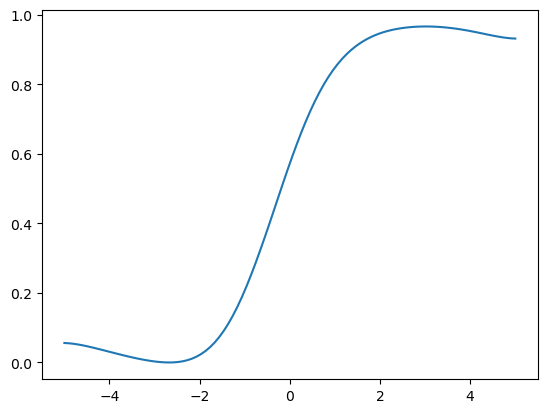

In [141]:
plt.plot(x,out.memberships[:,0])
print(entropy(out.memberships[:,0]))

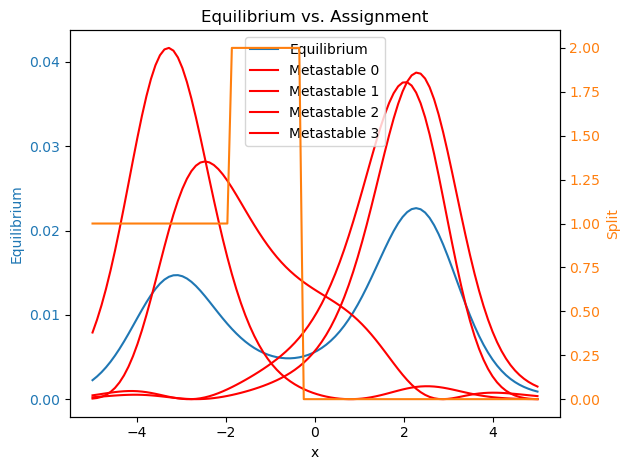

In [142]:
fig, ax1 = plt.subplots()
# First plot: equilibrium distribution
ax1.plot(x, p_eq, color='tab:blue', label="Equilibrium")
ax1.set_ylabel("Equilibrium", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

for i in range(N_splits):
    ax1.plot(x,out.metastable_distributions[i,:],label=f"Metastable {i}",c="red")

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(x, out.assignments, color='tab:orange', label="Split")
ax2.set_ylabel("Split", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Shared x-axis
ax1.set_xlabel("x")
plt.title("Equilibrium vs. Assignment")
fig.tight_layout()
ax1.legend()
plt.show()

## Minibatch Kmeans

Cluster centers (estimated):
[[-0.01844946 -0.00528982]
 [ 4.97781243  4.99673356]
 [-5.01424301  5.02722253]]


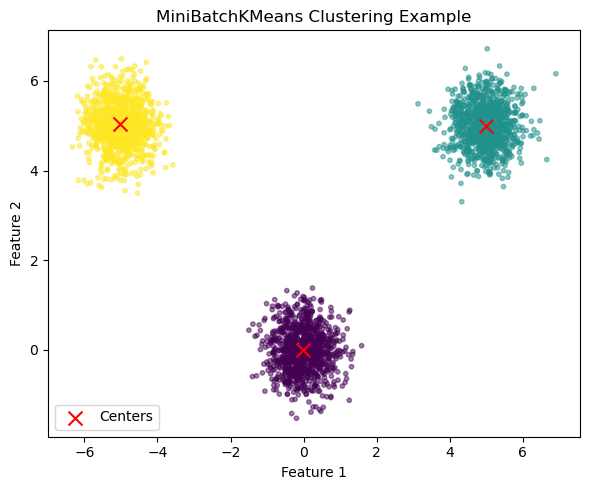

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# Generate dummy data
np.random.seed(0)
true_centers = np.array([[0, 0], [5, 5], [-5, 5]])
X = np.vstack([
    true_centers[0] + 0.5 * np.random.randn(1000, 2),
    true_centers[1] + 0.5 * np.random.randn(1000, 2),
    true_centers[2] + 0.5 * np.random.randn(1000, 2),
])

# Fit MiniBatchKMeans
mbk = MiniBatchKMeans(n_clusters=3, batch_size=100, random_state=0)
mbk.fit(X)
labels = mbk.labels_
centers = mbk.cluster_centers_

# Print cluster centers
print("Cluster centers (estimated):")
print(centers)

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Centers')
plt.title("MiniBatchKMeans Clustering Example")
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()


## Bayesian Gaussian Mixture

[0.00035735 0.00035723 0.33382331 0.00035689 0.00035754 0.33463072
 0.00035611 0.00035572 0.16229651 0.16710861]
Significant components (weight > uniform):
Component 2: center=[-0.00831616 -0.00260063], weight=0.334
Component 5: center=[-4.98174484  5.00052251], weight=0.335
Component 8: center=[4.67618374 5.90662232], weight=0.162
Component 9: center=[5.14453775 4.12807744], weight=0.167


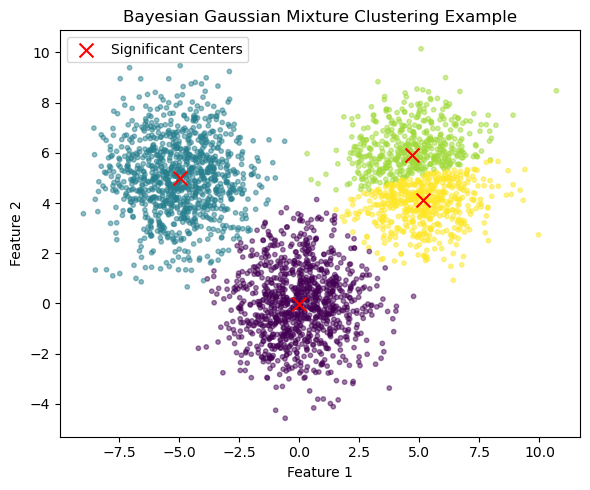

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture

# Generate dummy data
np.random.seed(0)
true_centers = np.array([[0, 0], [5, 5], [-5, 5]])
X = np.vstack([
    true_centers[0] + 1.5 * np.random.randn(1000, 2),
    true_centers[1] + 1.5 * np.random.randn(1000, 2),
    true_centers[2] + 1.5 * np.random.randn(1000, 2),
])

# Fit BayesianGaussianMixture with Dirichlet Process prior
bgm = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=1e-2,
    max_iter=1000,
    random_state=0
)
bgm.fit(X)
labels = bgm.predict(X)
centers = bgm.means_

# Filter out negligible components
weights = bgm.weights_
significant = weights > (1.0 / len(weights))

print(weights)
# Print significant centers and weights
print("Significant components (weight > uniform):")
for idx in np.where(significant)[0]:
    print(f"Component {idx}: center={centers[idx]}, weight={weights[idx]:.3f}")

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', alpha=0.5)
plt.scatter(centers[significant, 0], centers[significant, 1],
            c='red', marker='x', s=100, label='Significant Centers')
plt.title("Bayesian Gaussian Mixture Clustering Example")
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()


/tmp/ipykernel_145696/1032112872.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


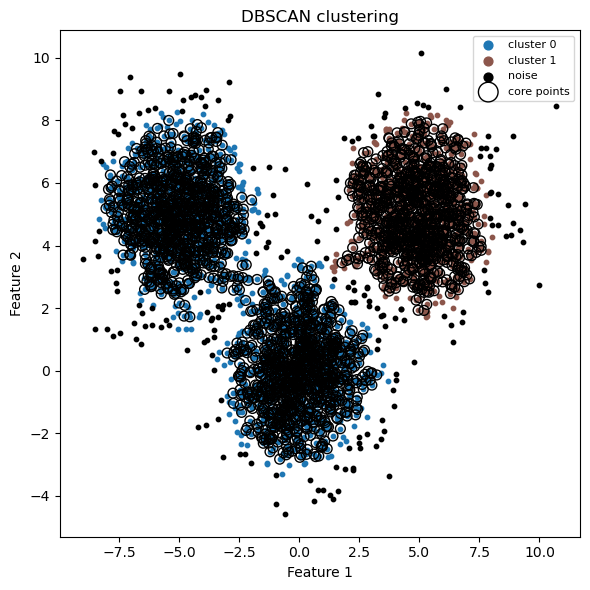

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Assuming X is your (N,2) array of data points
db = DBSCAN(eps=0.5, min_samples=10)
labels = db.fit_predict(X)

# Identify core samples, noise
core_samples = db.core_sample_indices_
unique_labels = set(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

plt.figure(figsize=(6,6))
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    if k == -1:
        # Noise
        plt.scatter(xy[:,0], xy[:,1], c='k', s=10, label='noise')
    else:
        plt.scatter(xy[:,0], xy[:,1], c=[colors(k)], s=10, label=f'cluster {k}')
# highlight core points
plt.scatter(X[core_samples,0], X[core_samples,1], facecolors='none',
            edgecolors='k', s=50, label='core points')

plt.legend(markerscale=2, fontsize=8)
plt.title('DBSCAN clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()
